<b><font size=5, color='#A020F0'>Calculating and explaining precipitation movement</font></b>

The inspiration of this experiment is from morph technique, an algorithm to produce near-real-time global precipitation observations in IMERG. 

In this notebook, I will use two method and three types of data to calculate precipitation movement, including total precipitable water Vapor (TQV), winds speed at 850 mb (U850, V850) and StageIV observations. The aim is to evaluate the role of TQV and UV850 in the movement of actual precipitation field. 

In [3]:
import numpy as np
import xarray as xr
from scipy.stats import pearsonr
from pysteps import motion

# see AOSproject.py
from AOSproject import Heidke_Skill,NRMSE,Motion_Vector_Cal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

D:\anoconda\envs\pysteps1\Lib\site-packages\pyproj\__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Pysteps configuration file found at: D:\anoconda\envs\pysteps1\Lib\site-packages\pysteps\pystepsrc



## 1. Data preparation

`MERRA2_0.1.2018.5_9.hourly.nc` is hourly, 0.5 by 0.625 deg dataset, with U850, V850 and TQV stored. The time span is from 5/1/2018 to 9/30/2018. the coverage is 45N-35N and 100W-85W. This data is downlaoded from https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/. 

`STAGEIV2018_0.1deg.3_10.hourly.nc` is hourly, 0.1 by 0.1 deg precipitation data, with the same coverage as MERRA-2. It is from 3/1/2018 to 10/31/2018. This data is download from https://data.eol.ucar.edu/dataset/21.093. Reprojection was conducted.

To make calculation less complex, I resize the MERRA-2 and StageIV data to 0.5 by 0.5 deg.

In [4]:
dsmerra= xr.open_dataset("MERRA2_0.1.2018.5_9.hourly.nc")
dsmerra['lon']=dsmerra['longitude']
dsmerra['lat']=dsmerra['latitude']

dsmerra=dsmerra.interp(lat=np.arange(44.75,35.05,-0.5),lon=np.arange(-99.75,-85.0,0.5),method="linear")

TQV= dsmerra['TQV']
dsmerra  #0.5 deg 0.625 deg

<xarray.Dataset>
Dimensions:    (time: 3672, lat: 20, lon: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01 ... 2018-09-30T23:00:00
  * lat        (lat) float64 44.75 44.25 43.75 43.25 ... 36.75 36.25 35.75 35.25
  * lon        (lon) float64 -99.75 -99.25 -98.75 ... -86.25 -85.75 -85.25
Data variables:
    latitude   (lat) float64 44.75 44.25 43.75 43.25 ... 36.75 36.25 35.75 35.25
    longitude  (lon) float64 -99.75 -99.25 -98.75 ... -86.25 -85.75 -85.25
    U850       (time, lat, lon) float64 3.397 2.603 2.925 ... -1.946 -1.946
    V850       (time, lat, lon) float64 -7.843 -4.033 0.7324 ... 3.715 3.963
    TQV        (time, lat, lon) float64 25.1 25.48 26.21 ... 35.79 36.12 36.11

In [5]:
dstage =xr.open_dataset("D:\!WISC_Res\STREAM\data\STAGEIV2018_0.1deg.3_10.hourly.nc")

dstage['lon']=dstage['longitude']
dstage['lat']=dstage['latitude']

dstage=dstage.interp(lat=np.arange(44.75,35.05,-0.5),lon=np.arange(-99.75,-85.0,0.5),method="linear")
dstage

<xarray.Dataset>
Dimensions:    (time: 5880, lat: 20, lon: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-03-01 ... 2018-10-31T23:00:00
  * lat        (lat) float64 44.75 44.25 43.75 43.25 ... 36.75 36.25 35.75 35.25
  * lon        (lon) float64 -99.75 -99.25 -98.75 ... -86.25 -85.75 -85.25
Data variables:
    latitude   (lat) float64 44.75 44.25 43.75 43.25 ... 36.75 36.25 35.75 35.25
    longitude  (lon) float64 -99.75 -99.25 -98.75 ... -86.25 -85.75 -85.25
    prcp       (lat, lon, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [6]:
StageH=dstage['prcp']

xsizeF=np.shape(StageH)[1]
ysizeF=np.shape(StageH)[0]
tsizeF=np.shape(StageH)[2]

# select study period
start='2018-08-14T17:00:00'
endt='2018-08-14T18:00:00'
dt=1 #hr
StageH1=StageH.sel(time=start)

## 2. Precipitation movement calculation

### 2.1 Morphing space interpolation

In `Motion_Vector_Cal`, pixels in the neighborhood are compared to the next half hour fields with different spatial offsets. The offset with the highest correlation forms the motion vector for that grid box. 

w is the size of neighborhood used to calculate the motion vector.

In [7]:
w=5
TQV1=TQV.sel(time=start)
TQV2=TQV.sel(time=endt)

T1,T2= Motion_Vector_Cal(TQV1.data,TQV2.data,w) #V,U

`Notes`: this step may need 20 seconds, I appreciate your patience on this!

In [8]:
dsmerra['TQV_U']=xr.DataArray(T2,dims=['lat','lon'])  #U east ward
dsmerra['TQV_V']=xr.DataArray(T1,dims=['lat','lon'])   #V southward

I propogate precipitation using the calculated motion vector from MERRA-2-TQV

A semi-lagrangian scheme rather than strictly Lagrangian is adapted, because it does not allow some pixels to be empty.

To make the movement be consistent with row index, southward movement is positive

In [9]:
# index for new precipitation field
yind=np.repeat(np.arange(0,ysizeF),xsizeF).reshape(ysizeF,xsizeF).astype('int16')
xind=np.tile(np.arange(0,xsizeF),ysizeF).reshape(ysizeF,xsizeF).astype('int16')

# propogation using TQV
yafter=np.array((yind-dsmerra['TQV_V'].data),dtype='int16')
xafter=np.array((xind-dsmerra['TQV_U'].data),dtype='int16')

# for the movement exceeding the study region
yafter[yafter>=ysizeF]=ysizeF-1
xafter[xafter>=xsizeF]=xsizeF-1
yafter[yafter<0]=0
xafter[xafter<0]=0

# get the propogated precipitation
newprcpTQV=StageH1.data[yafter,xafter]

### 2.2 UV850 transform

Again, using U850 and V850 in MERRA-2 to propogate the precipitation.
Note that the unit of U850, V850 is m/s. The unit of calculted motion vector is number of grid.

In [10]:
R=6371000
deltaU=dsmerra['U850'].sel(time=start)*60*60*dt // (np.cos(dsmerra['latitude']/180*np.pi)*R*0.625/180*np.pi)  # distance with unit m
deltaV=-dsmerra['V850'].sel(time=start)*60*60*dt // (R*0.5/180*np.pi)  # distance with unit m  
# note deltaV here is southward

In [11]:
yafter=np.array((yind-deltaV),dtype='int16')
xafter=np.array((xind-deltaU),dtype='int16')

yafter[yafter>=ysizeF]=ysizeF-1
xafter[xafter>=xsizeF]=xsizeF-1
yafter[yafter<0]=0
xafter[xafter<0]=0

newprcp850=StageH1.data[yafter,xafter]

### 2.3 Comparison between TQV and UV850

I draw the two types of motion vectors

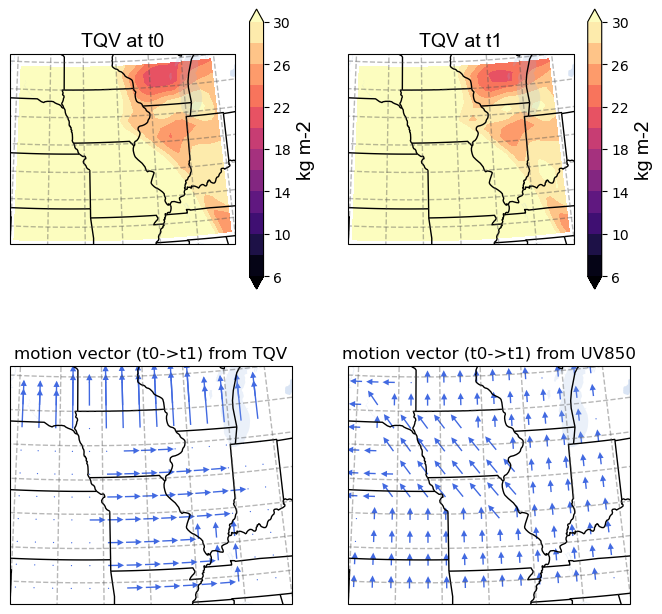

In [12]:
fig,ax=plt.subplots(2,2,subplot_kw={'projection':ccrs.LambertConformal()},figsize=(8,8))
axs=ax.flatten()
plt.sca(axs[0])
cs=axs[0].contourf(dsmerra.longitude,dsmerra.latitude,TQV1,
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),levels=range(6,32,2),extend='both')
axs[0].set_title('TQV at t0',font='arial',fontsize=14)

plt.sca(axs[1])
cs=axs[1].contourf(dsmerra.longitude,dsmerra.latitude,TQV2,
                    cmap=plt.cm.magma,transform=ccrs.PlateCarree(),levels=range(6,32,2),extend='both')
axs[1].set_title('TQV at t1',font='arial',fontsize=14)

axs[2].quiver(dsmerra.longitude[::2],dsmerra.latitude[::2],dsmerra['TQV_U'][::2,::2].data,
              -dsmerra['TQV_V'][::2,::2].data,
          transform=ccrs.PlateCarree(),color='royalblue',headwidth=4.5,headlength=4.5)
axs[2].set_title('motion vector (t0->t1) from TQV')

axs[3].quiver(dsmerra.longitude[::2],dsmerra.latitude[::2],deltaU[::2,::2].data,-deltaV[::2,::2].data,
          transform=ccrs.PlateCarree(),color='royalblue',headwidth=4.5,headlength=4.5)
axs[3].set_title('motion vector (t0->t1) from UV850')

for i in range(0,4):
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    
    axs[i].set_extent([-100,-85,45, 35],ccrs.PlateCarree())
    axs[i].add_feature(cfeature.LAKES, alpha=0.2)
    axs[i].add_feature(states_provinces, edgecolor='black')

    gl = axs[i].gridlines(color='0.3',alpha=0.4,linewidth=1,linestyle='--') #
for i in range(0,2):
    cbar=plt.colorbar(cs,ax=axs[i],orientation='vertical')
    cbar.set_label('kg m-2',font='arial',fontsize=14)

The direction of movement is different at some pixels. The left figure has some abrupt changes due to the imperfect algorithm.

In [14]:
dsmerra['U850shift']=xr.DataArray(deltaU,dims=['lat','lon'])
dsmerra['V850shift']=xr.DataArray(deltaV,dims=['lat','lon'])
dsmerra['newprcp850']=xr.DataArray(newprcp850,dims=['lat','lon'])
dsmerra['newprcpTQV']=xr.DataArray(newprcpTQV,dims=['lat','lon'])

I draw the propogated precipitation 

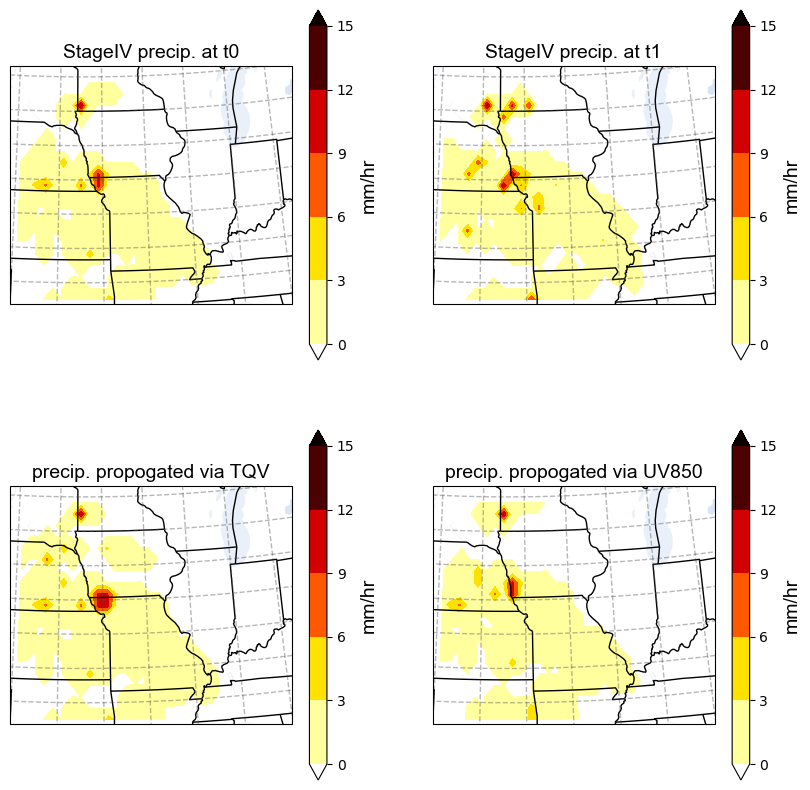

In [15]:
levels=range(6,32,2)

fig,ax=plt.subplots(2,2,subplot_kw={'projection':ccrs.LambertConformal()},figsize=(10,10))
axs=ax.flatten()
plt.sca(axs[0])
cs=axs[0].contourf(dstage.longitude,dstage.latitude,StageH.sel(time=start),
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,18,3))
axs[0].set_title('StageIV precip. at t0',font='arial',fontsize=14)

plt.sca(axs[1])
cs=axs[1].contourf(dstage.longitude,dstage.latitude,StageH.sel(time=endt),
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,18,3))
axs[1].set_title('StageIV precip. at t1',font='arial',fontsize=14)

plt.sca(axs[2])
cs=axs[2].contourf(dstage.longitude,dstage.latitude,dsmerra['newprcpTQV'],
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,18,3))
axs[2].set_title('precip. propogated via TQV',font='arial',fontsize=14)

plt.sca(axs[3])
cs=axs[3].contourf(dstage.longitude,dstage.latitude,dsmerra['newprcp850'],
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,18,3))
axs[3].set_title('precip. propogated via UV850',font='arial',fontsize=14)

for i in range(0,4):
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    
    axs[i].set_extent([-100,-85,45, 35],ccrs.PlateCarree())
    axs[i].add_feature(cfeature.LAKES, alpha=0.2)
    axs[i].add_feature(states_provinces, edgecolor='k')

    gl = axs[i].gridlines(color='0.3',alpha=0.4,linewidth=1,linestyle='--') #
    cbar=plt.colorbar(cs,ax=axs[i],orientation='vertical')
    cbar.set_label('mm/hr',font='arial',fontsize=14)


Here only movement is considered, it is not perfect to produce real precipitation. 
For TQV: it captures eastward movement near IL. For UV850, Northward movement in KS. But some false alarms were produced in TQV

To evaluate above motion vector, I use pearsonR, Heidke_Skill,NRMSE to assess the propogated precipitation with the real precipitation. A higher pearsonR and Heidke_Skill, a lower NRMSE mean better presiction

In [16]:
realPrcp=StageH.sel(time=endt).data

R_TQV=pearsonr(newprcpTQV.flatten(), realPrcp.flatten())[0]
HS_TQV=Heidke_Skill(realPrcp,newprcpTQV)
NRMSE_TQV=NRMSE(realPrcp,newprcpTQV)

R_850=pearsonr(newprcp850.flatten(), realPrcp.flatten())[0]
HS_850=Heidke_Skill(newprcp850,realPrcp)
NRMSE_850=NRMSE(realPrcp,newprcp850)

print('propogated precipitation from TQV:')
print("pearson R=%0.02f"%(R_TQV))
print("Heidke_Skill=%0.02f"%(HS_TQV))
print("NRMSE=%0.02f"%(NRMSE_TQV))

print('propogated precipitation from UV850:')
print("pearson R=%0.02f"%(R_850))
print("Heidke_Skill=%0.02f"%(HS_850))
print("NRMSE=%0.02f"%(NRMSE_850))

propogated precipitation from TQV:
pearson R=0.35
Heidke_Skill=0.60
NRMSE=4.19
propogated precipitation from UV850:
pearson R=0.30
Heidke_Skill=0.54
NRMSE=4.15


The two kinds of precipitation field do not differ a lot. 

## 3. Actual motion vector from optical flow

Look back to the precipitation data, I calculate motion vector just based on the Stage IV observations, and make a comparison with aboved motion vector. Since the rainfall is sparse, the above method is not good. I use optical flow here to track the movement of rainfall. 

In [17]:
Stage12=StageH.sel(time=slice(start,endt))
oflow_method = motion.get_method("VET")  # 
Stage_VLK = oflow_method(np.transpose(Stage12.data,[2,0,1]))

Running VET algorithm
original image shape: (2, 20, 30)
padded image shape: (2, 20, 30)
padded template_image image shape: (2, 20, 30)

Number of sectors: 2,2
Sector Shape: (10, 15)
Minimizing

residuals 722.0013790339835
smoothness_penalty 0.0
original image shape: (2, 20, 30)
padded image shape: (2, 20, 32)
padded template_image image shape: (2, 20, 32)

Number of sectors: 4,4
Sector Shape: (5, 8)
Minimizing

residuals 840.6439048309257
smoothness_penalty 193.40000566173717
original image shape: (2, 20, 30)
padded image shape: (2, 32, 32)
padded template_image image shape: (2, 32, 32)

Number of sectors: 16,16
Sector Shape: (2, 2)
Minimizing

residuals 839.664407750291
smoothness_penalty 1333.8222697600893
original image shape: (2, 20, 30)
padded image shape: (2, 32, 32)
padded template_image image shape: (2, 32, 32)

Number of sectors: 32,32
Sector Shape: (1, 1)
Minimizing

residuals 840.0141916596658
smoothness_penalty 5097.334406543143


In [18]:
yafter=np.array((yind-Stage_VLK[1,:,:]),dtype='int16')
xafter=np.array((xind-Stage_VLK[0,:,:]),dtype='int16')
yafter[yafter>=ysizeF]=ysizeF-1
xafter[xafter>=xsizeF]=xsizeF-1
yafter[yafter<0]=0
xafter[xafter<0]=0
newprcpStage=StageH1.data[yafter,xafter]

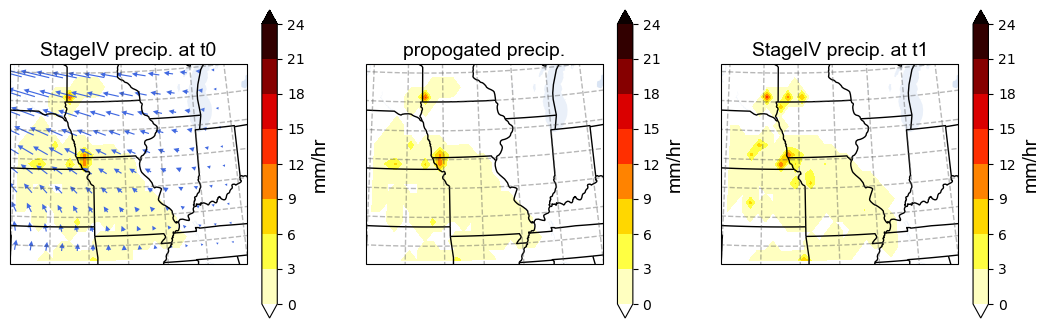

In [19]:
fig,ax=plt.subplots(1,3,subplot_kw={'projection':ccrs.LambertConformal()},figsize=(13,4))
axs=ax.flatten()
plt.sca(axs[0])
cs=axs[0].contourf(dstage.longitude,dstage.latitude,StageH.sel(time=start),
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,25,3))
axs[0].quiver(dsmerra.longitude[::2],dsmerra.latitude[::2],Stage_VLK[0,::2,::2],-Stage_VLK[1,::2,::2],
          transform=ccrs.PlateCarree(),color='royalblue',headwidth=4.5,headlength=4.5)
axs[0].set_title('StageIV precip. at t0',font='arial',fontsize=14)

plt.sca(axs[1])
cs=axs[1].contourf(dstage.longitude,dstage.latitude,newprcpStage,
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,25,3))
axs[1].set_title('propogated precip.',font='arial',fontsize=14)

plt.sca(axs[2])
cs=axs[2].contourf(dstage.longitude,dstage.latitude,StageH.sel(time=endt),
                    cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),extend='both',levels=np.arange(0,25,3))
axs[2].set_title('StageIV precip. at t1',font='arial',fontsize=14)


states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

for i in range(0,3):
    axs[i].set_extent([-100,-85,45, 35],ccrs.PlateCarree())
    axs[i].add_feature(cfeature.LAKES, alpha=0.2)
    axs[i].add_feature(states_provinces, edgecolor='k')

    gl = axs[i].gridlines(color='0.3',alpha=0.4,linewidth=1,linestyle='--') #
    cbar=plt.colorbar(cs,ax=axs[i],orientation='vertical')
    cbar.set_label('mm/hr',font='arial',fontsize=14)

## 4. Comparison bwteen motion vectors

furthermore, I calculate the  meridional and zonal mean movement, and make a compariso. 

In [20]:
dsmerra['Stage_U']=xr.DataArray(Stage_VLK[0,:,:],dims=['lat','lon'])
dsmerra['Stage_V']=xr.DataArray(Stage_VLK[1,:,:],dims=['lat','lon'])

Text(0.5, 1.0, 'zonal mean MV')

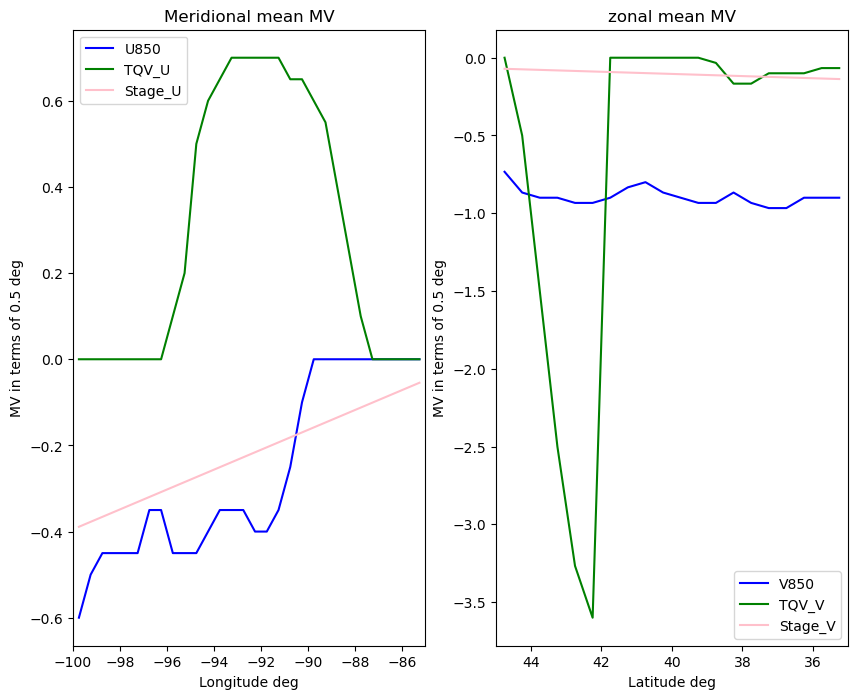

In [21]:
# accuracy at magnitude and speed in both the longitudinal and latitudinal directions.
# meridional gradient of the zonal mean temperature
U850_me=dsmerra['U850shift'].mean(dim='lat')
V850_zn=dsmerra['V850shift'].mean(dim='lon')

TQV_U_me=dsmerra['TQV_U'].mean(dim='lat')
TQV_V_zn=dsmerra['TQV_V'].mean(dim='lon')

StageU_me=dsmerra['Stage_U'].mean(dim='lat')
StageV_zn=dsmerra['Stage_V'].mean(dim='lon')

fig,ax=plt.subplots(1,2,figsize=(10,8))
ax[0].plot(dsmerra['lon'],U850_me.data,c='blue',label='U850')
ax[0].plot(dsmerra['lon'],TQV_U_me.data,c='green',label='TQV_U')
ax[0].plot(dsmerra['lon'],StageU_me.data,c='pink',label='Stage_U')

ax[0].legend()
ax[0].set_xlim(-100,-85)
ax[0].set_xlabel('Longitude deg')
ax[0].set_ylabel('MV in terms of 0.5 deg')
ax[0].set_title('Meridional mean MV')

ax[1].plot(dsmerra['lat'],V850_zn.data,c='blue',label='V850')
ax[1].plot(dsmerra['lat'],TQV_V_zn.data,c='green',label='TQV_V')
ax[1].plot(dsmerra['lat'],StageV_zn.data,c='pink',label='Stage_V')

ax[1].legend()
ax[1].set_xlim(45,35)
ax[1].set_xlabel('Latitude deg')
ax[1].set_ylabel('MV in terms of 0.5 deg')
ax[1].set_title('zonal mean MV')


Unfortuunately, We see some errors in the calculation of motion vector using morphing techniques. And the results is over smooth for optical flow. 

The above experiments can answer our question partly. We generally see the similar movement trend between UV 850 and movement of StageIV. But the motion vector from TQV sometimes have the opposite direction compared with Stage IV movement. Sometimes, It overestimates the northward movement.

## 5. Conclusions:

1. UV850 is a better explantion for precipitation data movement, compared with TQV. This also has been proved in pevious research.

2. winds spped at 850 mb can explain about 30% of precipitation field movement.

3. the changes in precipitation magitide, not only the advection of water volume, is important.
